In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
md = pd.read_csv('/Users/mainoahmuna/Google Drive/My Drive/Team-Fermata-Energy/processed_data/md_one_hot_encoded.csv')
PATH = '/Users/mainoahmuna/Google Drive/My Drive/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp'
json_file = '../data/subset20_data.json'

In [6]:
def load_building_ids(json_file_path):
    """
    Load train and test building IDs from a JSON file.

    Parameters:
        json_file (str): Path to the JSON file containing building IDs.

    Returns:
        tuple: Two lists, one for training building IDs and one for testing building IDs.
    """
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    train_bldg_ids = data.get("train_bldg_ids", [])
    test_bldg_ids = data.get("test_bldg_ids", [])
    return train_bldg_ids, test_bldg_ids

In [7]:
def smape(actual, predicted):
    """
    Calculate SMAPE (Symmetric Mean Absolute Percentage Error) between actual and predicted values.
    """
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = np.abs(actual) + np.abs(predicted)
    diff = np.abs(actual - predicted) / denominator
    diff[denominator == 0] = 0.0  # Handle division by zero
    return 200 * np.mean(diff)

In [8]:
def create_df(df_load, md):
    """
    Create Y and X variables for linear regression model.

    Parameters:
        df_load (pandas.DataFrame): DataFrame containing load data.

    Returns:
        tuple: Tuple containing Y and X variables.  
    """
    for i in range(1, 97):
        df_load[f"shift_{i}"] = df_load["out.electricity.total.energy_consumption"].shift(i)

    df_load = df_load.dropna()

    # Merge load data with metadata based on `building_id`
    merged_df = df_load.merge(md, on='bldg_id', how='left')

    merged_df = merged_df.drop(['bldg_id'], axis=1)
    
    return merged_df

In [9]:
def train_sarimax_model(df, target_column, order=(1, 1, 1), seasonal_order=(0, 1, 1, 96)):
    """
    Train a SARIMAX model on the provided DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the time series data.
        target_column (str): Column name of the target variable.
        order (tuple): SARIMA order (p, d, q).
        seasonal_order (tuple): Seasonal order (P, D, Q, s).
    
    Returns:
        SARIMAXResults: The trained SARIMAX model.
    """
    model = SARIMAX(df[target_column], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
    results = model.fit(disp=False)
    return results

In [10]:
def predict_sarimax_model(model, steps, exog=None):
    """
    Use a trained SARIMAX model to predict future values.

    Parameters:
        model (SARIMAXResults): Trained SARIMAX model.
        steps (int): Number of steps to predict.
        exog (pandas.DataFrame, optional): Exogenous variables for forecasting.

    Returns:
        pandas.DataFrame: Predictions with confidence intervals.
    """
    forecast = model.get_forecast(steps=steps, exog=exog)
    forecast_df = forecast.conf_int()
    forecast_df['mean'] = forecast.predicted_mean
    return forecast_df

In [11]:
def evaluate_sarimax_model(model, train_data, test_data, steps, exog_train=None, exog_test=None):
    """
    Evaluate SARIMAX model by calculating SMAPE for training and testing data.
    
    Parameters:
        model (SARIMAXResults): Trained SARIMAX model.
        train_data (pandas.Series): Training data (endogenous variable).
        test_data (pandas.Series): Testing data (endogenous variable).
        steps (int): Number of steps to predict in testing data.
        exog_train (pandas.DataFrame, optional): Exogenous variables for training.
        exog_test (pandas.DataFrame, optional): Exogenous variables for testing.
    
    Returns:
        tuple: SMAPE for training and testing data.
    """
    # Get in-sample predictions for training data
    train_forecast = model.get_prediction(start=train_data.index[0], end=train_data.index[-1], exog=exog_train)
    train_predicted = train_forecast.predicted_mean
    
    # Calculate SMAPE for training
    smape_train = smape(train_data, train_predicted)
    
    # Get out-of-sample predictions for testing data
    test_forecast = model.get_forecast(steps=steps, exog=exog_test)
    test_predicted = test_forecast.predicted_mean
    
    # Align predictions with actual test data
    test_predicted_index = test_data.index[:steps]
    test_predicted = test_predicted.loc[test_predicted_index]
    
    # Calculate SMAPE for testing
    smape_test = smape(test_data.loc[test_predicted_index], test_predicted)
    
    return smape_train, smape_test

In [12]:
df_test = pd.read_csv('/Users/mainoahmuna/Google Drive/My Drive/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/32.csv')

In [13]:
def load_data_for_building(filename, directory):
    """
    Load the data for a specific building from CSV.
    """
    try:
        df = pd.read_csv(f"{directory}/{filename}")
        return df
    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        return None

In [14]:
def train_sarimax_model_with_downsampling(directory, train_bldg_ids, test_bldg_ids, target_column='out.electricity.total.energy_consumption', steps=96, chunk_size=1000, downsample_rate=4):
    """
    Train and test the SARIMAX model using downsampled data from building CSV files.

    Parameters:
        directory (str): Path to the directory containing building CSV files.
        train_bldg_ids (list): List of building IDs (file names) for training.
        test_bldg_ids (list): List of building IDs (file names) for testing.
        target_column (str): The name of the target column.
        steps (int): Number of steps to predict for each test.
        chunk_size (int): Number of rows to process in each chunk.
        downsample_rate (int): Factor by which to downsample the training data.

    Returns:
        dict: Results containing trained models, predictions, SMAPE scores, and visualizable results.
    """
    smape_train_list = []
    smape_test_list = []
    detailed_results = []

    # Training phase
    for filename in tqdm(train_bldg_ids, desc="Training on buildings", unit="file"):
        try:
            train_df = load_data_for_building(filename, directory)
            if train_df is None or target_column not in train_df:
                print(f"Skipping {filename} due to missing data.")
                continue

            train_df = train_df.sort_index()  # Ensure data is sorted by timestamp

            # Downsample the training data
            #train_df = train_df.iloc[::downsample_rate, :]  # Sample every Nth row

            # Handle missing values
            if train_df[target_column].isnull().any():
                print(f"Missing values in {filename}, skipping.")
                continue

            # Fit the SARIMAX model
            model = SARIMAX(
                train_df[target_column],
                order=(1, 1, 1),  # Adjust these parameters if necessary
                seasonal_order=(1, 1, 1, 24 // downsample_rate),  # Seasonal frequency adjusted for downsampling
                initialization='approximate_diffuse'
            )
            model_fit = model.fit(disp=False)

            # Calculate training SMAPE
            smape_train = smape(train_df[target_column], model_fit.fittedvalues)
            smape_train_list.append(smape_train)

        except Exception as e:
            print(f"Error processing file {filename} during training: {e}")
            continue

    # Testing phase
    for filename in tqdm(test_bldg_ids, desc="Testing on buildings", unit="file"):
        try:
            test_df = load_data_for_building(filename, directory)
            if test_df is None or target_column not in test_df:
                print(f"Skipping {filename} due to missing data.")
                continue

            test_df = test_df.sort_index()  # Ensure data is sorted by timestamp

            # Handle missing values
            if test_df[target_column].isnull().any():
                print(f"Missing values in {filename}, skipping.")
                continue

            # Fit the SARIMAX model on test data
            model = SARIMAX(
                test_df[target_column],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 24),
                initialization='approximate_diffuse'
            )
            model_fit = model.fit(disp=False)

            # Forecast
            forecast = model_fit.forecast(steps=steps)

            if len(test_df[target_column]) < steps:
                print(f"Not enough data in {filename} for forecasting {steps} steps.")
                continue

            # Compute SMAPE
            smape_test = smape(test_df[target_column][-steps:], forecast)
            smape_test_list.append(smape_test)

            # Detailed results
            detailed_results.append({
                'test_building': filename,
                'smape_train': smape_train_list[-1],
                'smape_test': smape_test,
                'predictions': forecast.tolist(),
                'actual': test_df[target_column][-steps:].tolist()
            })

        except Exception as e:
            print(f"Error processing file {filename} during testing: {e}")
            continue

    # Return results
    return smape_train_list, smape_test_list, detailed_results

In [15]:
train_id, test_id = load_building_ids(json_file)

In [33]:
smape_train_list, smape_test_list, detailed_results = train_sarimax_model_with_downsampling(PATH, train_id[3:5], test_id[2:4], downsample_rate=10)

Training on buildings:   0%|          | 0/2 [00:00<?, ?file/s]/Users/mainoahmuna/Downloads/Projects/FermataEnergy_BTTStudio/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Testing on buildings: 100%|██████████| 2/2 [03:25<00:00, 102.78s/file]


In [34]:
print(smape_test_list)

[np.float64(32.73212331914938), np.float64(40.50237499997685)]


In [36]:
avg_smape_train = sum(smape_train_list) / len(smape_train_list)
avg_smape_test = sum(smape_test_list) / len(smape_test_list)

In [37]:
print(avg_smape_train)
print(avg_smape_test)

3.6550472623098504
36.617249159563116


In [38]:
def visualize_results(detailed_results, num_buildings=5):
    """
    Visualize the SARIMAX model predictions versus actual values for selected buildings.

    Parameters:
        detailed_results (list): A list of dictionaries containing detailed results from the SARIMAX model.
        num_buildings (int): Number of buildings to visualize (default is 5).
    """
    # Ensure there are results to visualize
    if not detailed_results:
        print("No detailed results to visualize.")
        return

    # Select a subset of buildings to visualize
    selected_results = detailed_results[:num_buildings]
    
    # Set up the plot layout
    num_rows = len(selected_results)
    fig, axes = plt.subplots(num_rows, 1, figsize=(12, 5 * num_rows))
    
    # Ensure axes is always a list (even for a single building)
    if num_rows == 1:
        axes = [axes]

    # Plot predictions vs. actuals for each selected building
    for idx, result in enumerate(selected_results):
        ax = axes[idx]
        building = result['test_building']
        predictions = result['predictions']
        actual = result['actual']
        smape_train = result.get('smape_train', None)
        smape_test = result.get('smape_test', None)
        
        # Plot actual vs. predictions
        ax.plot(actual, label="Actual", color="blue", marker="o", linestyle="-")
        ax.plot(predictions, label="Predictions", color="orange", marker="x", linestyle="--")
        
        # Add title and labels
        ax.set_title(f"Building: {building}\nSMAPE Train: {smape_train:.2f}, SMAPE Test: {smape_test:.2f}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Electricity Consumption")
        ax.legend()
        ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [39]:
def visualize_24hr_forecast(detailed_results):
    """
    Visualize the SARIMAX model's predictions for the next 24 hours versus actual values.

    Parameters:
        detailed_results (list): A list of dictionaries containing detailed results from the SARIMAX model.
    """
    # Ensure there are results to visualize
    if not detailed_results:
        print("No detailed results to visualize.")
        return

    # Set up the plot layout
    num_buildings = len(detailed_results)
    fig, axes = plt.subplots(num_buildings, 1, figsize=(12, 5 * num_buildings))

    # Ensure axes is always a list (even for a single building)
    if num_buildings == 1:
        axes = [axes]

    # Plot predictions vs. actuals for each building
    for idx, result in enumerate(detailed_results):
        ax = axes[idx]
        building = result['test_building']
        predictions = result['predictions']
        actual = result['actual']
        smape_test = result.get('smape_test', None)

        # Ensure we have enough data to plot
        if len(actual) < 24 or len(predictions) < 24:
            print(f"Skipping visualization for {building}: Not enough data.")
            continue

        # Plot last 24 actual values and 24-hour forecast
        time_steps = range(-24, 0)
        ax.plot(time_steps, actual[-24:], label="Actual (Last 24 hrs)", color="blue", marker="o", linestyle="-")
        ax.plot(time_steps, predictions[:24], label="Predicted (Next 24 hrs)", color="orange", marker="x", linestyle="--")

        # Add title and labels
        ax.set_title(f"24-Hour Forecast for Building: {building}\nSMAPE Test: {smape_test:.2f}")
        ax.set_xlabel("Time Step (Hours Ago)")
        ax.set_ylabel("Electricity Consumption")
        ax.legend()
        ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


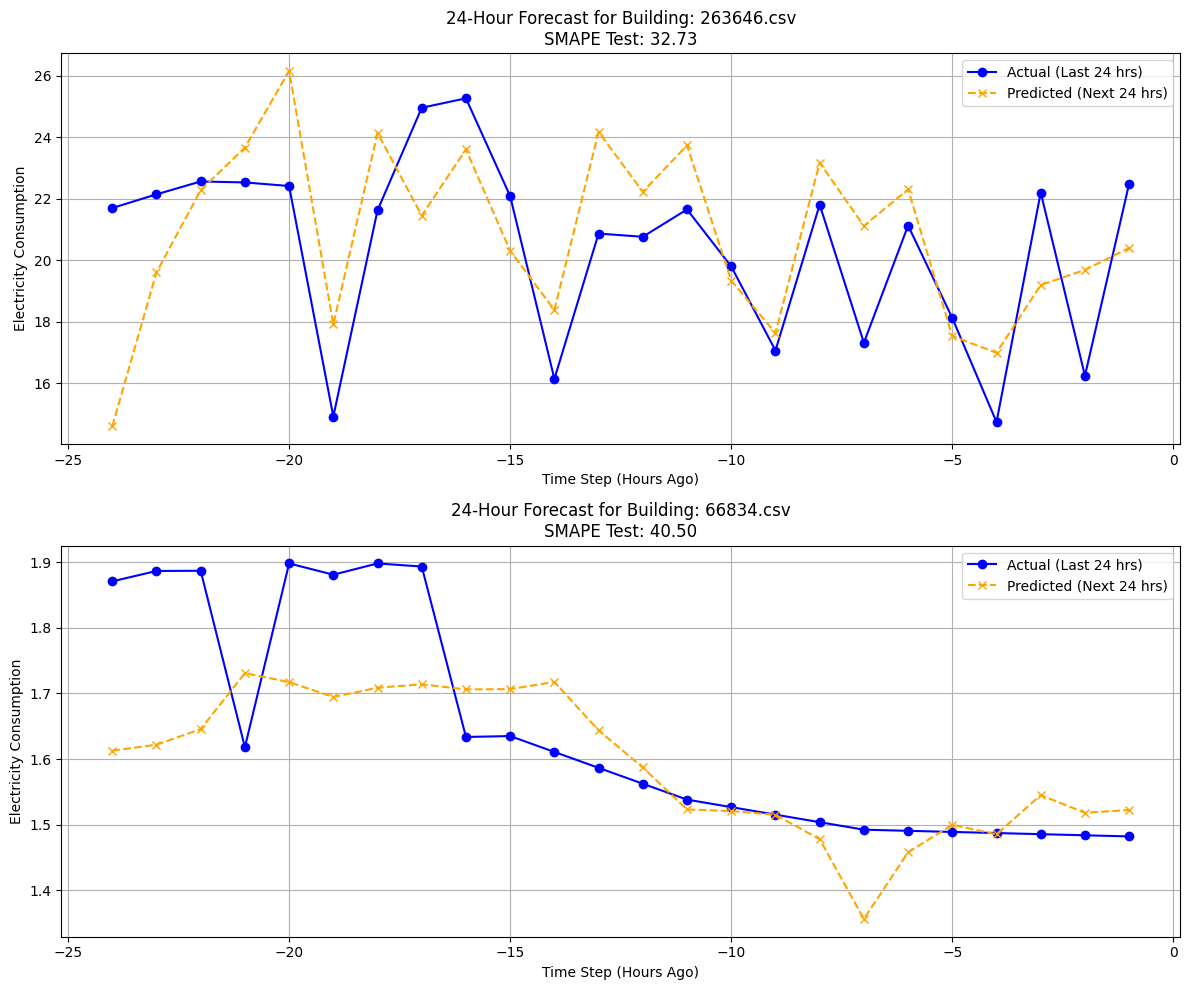

In [40]:
visualize_24hr_forecast(detailed_results)

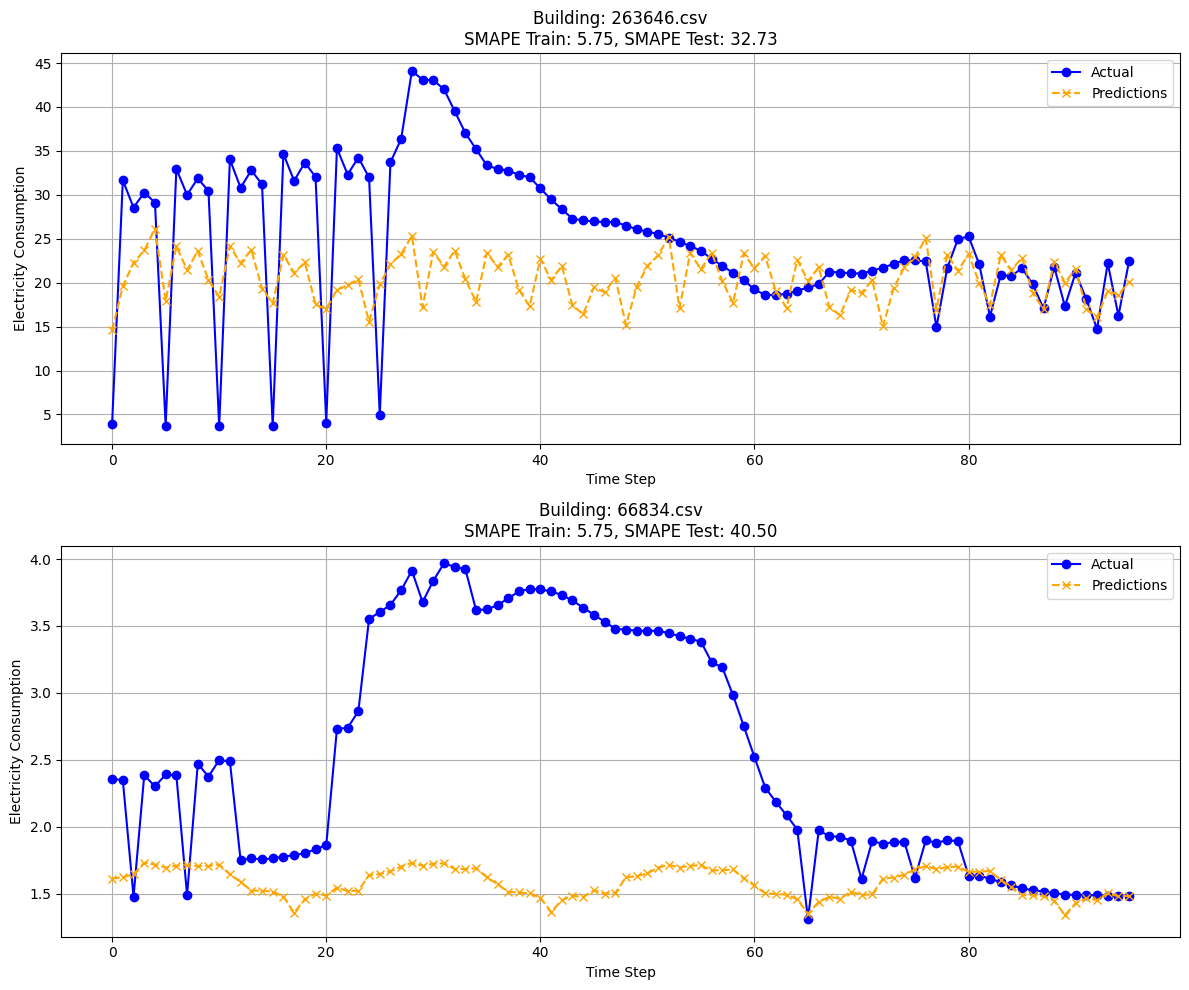

In [41]:
visualize_results(detailed_results, num_buildings=2)